# What is hidden in a randomly weighted neural network?

This is a small implementation of a fully connected neural network in numpy/cupy ( i switched to the latter since it took a long time on CPU, pretty interchangeable save for some parts of the code where the cupy array has to be converted to numpy array)

TL ; DR of the paper : Chonky neural nets contains wisdom. 

The paper explores the posibility of finding a good subnetwork inside a randomly initialized neural network that could perform well on a certain task. How the authors approach finding this subnetwork is by assigning a score corresponding to each weights, and during feedforward, only weights with a top K % score is considered. Optimization is done on the score, while weights are kept constant.

In this implementation, i observe how both approaches perform on a similar task : Digits classification in MNIST.

In [84]:
# import numpy as np
import cupy as np
import matplotlib.pyplot as plt

In [85]:
np.random.seed(69420)

# Implementation : Baseline

Since we need a comparison, we will first see how would a fully connected NN trained with normal backprop perform.

In [86]:
def glorot_init(shape):
    fan_out,fan_in = shape
    limit = np.sqrt(6/(fan_in+fan_out))
    params = np.random.uniform(low=limit*-1,high=limit,size=shape)
    return params

In [87]:
def kaiming_uniform(shape):
    fan_out, fan_in = shape
    params = np.random.normal(loc=0,scale=np.sqrt(2/fan_in),size=shape)
    return params

In [88]:
def relu(a,prime=False):
    if not prime:
        mask = a > 0
        return a * mask
    else:
        mask = a > 0
        return mask.astype(np.float32)

In [89]:
def softmax(a,prime=False):
    a = np.exp(a)
    a = a / np.sum(a,axis=0)
    return a

In [90]:
def targets_to_onehot(targets,numclass):
    onehot = np.zeros((numclass,len(targets)))
    onehot[targets,np.arange(len(targets))] = 1
    return onehot

In [91]:
def crossentropy_with_logits(logits_out, y,prime=False):
    num_classes, num_samples = logits_out.shape
    y_onehot = targets_to_onehot(y,num_classes)
    assert logits_out.shape == y_onehot.shape
    softmaxed = softmax(logits_out)
    if prime:
        softmaxed[y,np.arange(num_samples)] -=1
        return softmaxed
    else:
        return np.sum(np.nan_to_num(y_onehot * np.log(softmaxed) + (1-y_onehot) * np.log((1-softmaxed))))

In [92]:
def SGDOptimizer(gradients,parameters,learningrate):
    parameters = [p - learningrate * g for p,g in zip(parameters,gradients)]
    return parameters

In [93]:
def MomentumSGD(lr,m):
    vl = None
    def optimizer(grads,params):
        nonlocal vl
        if vl is None:
            vl = [np.zeros(p.shape) for p in params]
        vl = [m * v + lr * g for v,g in zip(vl,grads)]
        params = [p-v for p,v in zip(params,vl)]
        return params    
    return optimizer

In [127]:
class FCNN(object):
    
    def __init__(self, layers_size,initializer_weight,initializer_bias,activation,loss_function,optimizer_w,optimizer_b):
        self.layers_size = layers_size
        self.weights = [initializer_weight((k,j)) for j,k in zip(layers_size[:-1],layers_size[1:])]
        self.biases = [initializer_bias((k,1)) for k in layers_size[1:]]
        self.activation = activation
        self.loss_function = loss_function
        self.optimizer_w = optimizer_w
        self.optimizer_b = optimizer_b
    
    def feedforward(self,X):
        a = X
        zs = []
        acs = [a]
        for w,b in zip(self.weights,self.biases):
            a = np.dot(w,a) + b
#             print(a.shape)
            zs.append(a)
            a = self.activation(a)
            acs.append(a)
        return a, zs, acs
    
    def feedforward_softmax(self,X):
        final_a, _, _ = self.feedforward(X)
        final_a = np.exp(final_a)
#         print(final_a.shape)
        final_a = final_a / np.sum(final_a,axis=0)
        return final_a
    
    def backpropagation(self,X,y):
        input_dim, batch_size = X.shape
        final_activation, zs, acs = self.feedforward(X)
        delta_w = [np.zeros(w.shape) for w in self.weights]
        delta_b = [np.zeros(b.shape) for b in self.biases]
        error = self.loss_function(final_activation,y,prime=True) * self.activation(zs[-1],True)
        delta_w[-1] += np.einsum('ik,jk->ijk',error,acs[-2]).mean(axis=2)
        delta_b[-1] += np.expand_dims(error,1).mean(axis=2)
        for i in range(2,len(self.layers_size)):
            error = np.einsum('ik,ij->jk',error,self.weights[-i+1]) * self.activation(zs[-i],prime=True)
            delta_w[-i] += np.einsum('ik,jk->ijk',error,acs[-i-1]).mean(axis=2)
            delta_b[-i] += np.expand_dims(error,1).mean(axis=2) 
        return delta_w, delta_b
    
    def fit(self,X,y,batch_size,epochs):
        # expecting X and y to be already numpy array with the num_samples as 
        # 1st dim
        history = np.zeros(epochs + 1)
        history -= 1
        index = 0
        for epoch in range(epochs):
            indices = np.arange(X.shape[0],dtype=np.int32)
            np.random.shuffle(indices)
            X = X.copy()[indices,:]
            y = y.copy()[indices]
            i = 0
            batches_X = [X[k:k+batch_size] for k in range(0,X.shape[0],batch_size)]
            batches_y = [y[k:k+batch_size] for k in range(0,y.shape[0],batch_size)]
            losses = 0
            if index == 0:
                for Xb, yb in zip(batches_X,batches_y):
                    logits,_,_ = self.feedforward(Xb.T)
                    history[0] += self.loss_function(logits,yb.T) / (Xb.shape[0] * len(batches_X))
            for Xb, yb in zip(batches_X,batches_y):
                delta_w, delta_b = self.backpropagation(Xb.T, yb.T)
#                 print(delta_w)
                self.weights = self.optimizer_w(delta_w,self.weights)
                self.biases = self.optimizer_b(delta_b,self.biases)
                logits,_,_ = self.feedforward(Xb.T)
                losses += self.loss_function(logits,yb.T) / (Xb.shape[0] * len(batches_X))
#                 print((Xb.shape[0] * len(batches_X)))
            history[index] = losses
            index += 1
            print(f"Epoch {epoch} done. Loss : {losses}")
        return history
    
    def predict(self,X):
        softmaxed = self.feedforward_softmax(X.T)
        preds = np.argmax(softmaxed,axis=0)
        return preds
    
    def score(self, X, y):
        preds = self.predict(X)
        assert preds.shape == y.shape
        return np.mean(preds == y) * 100

In [117]:
mnist_data = np.load('../Dataset/Mnist/train.npy')

In [118]:
mnist_label = mnist_data[:,0]
mnist_pixels = mnist_data[:,1:] / 255

In [119]:
smol_batch_pixels = mnist_pixels[:32,:]
smol_batch_label = mnist_label[:32].astype(np.int32)

In [105]:
weight_optimizer = MomentumSGD(0.001,0.9)
bias_optimizer = MomentumSGD(0.001,0.9)
nn_overfit = FCNN([784,100,100,10],kaiming_uniform,kaiming_uniform,relu,crossentropy_with_logits,weight_optimizer,bias_optimizer)

In [106]:
hist = nn_overfit.fit(smol_batch_pixels,smol_batch_label,32,1000)

Epoch 0 done. Loss : -6.151712328535305
Epoch 1 done. Loss : -5.8161059118064635
Epoch 2 done. Loss : -5.396696778544478
Epoch 3 done. Loss : -4.936496743730764
Epoch 4 done. Loss : -4.484603691139053
Epoch 5 done. Loss : -4.124984104402594
Epoch 6 done. Loss : -3.9068446465089295
Epoch 7 done. Loss : -3.778181157755985
Epoch 8 done. Loss : -3.673248675488985
Epoch 9 done. Loss : -3.585712049406119
Epoch 10 done. Loss : -3.5371882397716283
Epoch 11 done. Loss : -3.5265466694856635
Epoch 12 done. Loss : -3.5308195102656637
Epoch 13 done. Loss : -3.5265185832371913
Epoch 14 done. Loss : -3.49882315001549
Epoch 15 done. Loss : -3.443549802355376
Epoch 16 done. Loss : -3.3644862246076723
Epoch 17 done. Loss : -3.2678614574298654
Epoch 18 done. Loss : -3.1623965457127197
Epoch 19 done. Loss : -3.0588359603543056
Epoch 20 done. Loss : -2.9669000810579678
Epoch 21 done. Loss : -2.8913629017905267
Epoch 22 done. Loss : -2.8337520592688317
Epoch 23 done. Loss : -2.7909601739003578
Epoch 24 done

Epoch 203 done. Loss : -1.064866778427814
Epoch 204 done. Loss : -1.0628525509692075
Epoch 205 done. Loss : -1.0608597188165776
Epoch 206 done. Loss : -1.0588989233748265
Epoch 207 done. Loss : -1.0569624282554704
Epoch 208 done. Loss : -1.055050061158751
Epoch 209 done. Loss : -1.053167326528159
Epoch 210 done. Loss : -1.0513072933274694
Epoch 211 done. Loss : -1.049473432883137
Epoch 212 done. Loss : -1.0476546955985242
Epoch 213 done. Loss : -1.0458639816163369
Epoch 214 done. Loss : -1.044100283798847
Epoch 215 done. Loss : -1.0423543468731005
Epoch 216 done. Loss : -1.0406343753740859
Epoch 217 done. Loss : -1.038931240672045
Epoch 218 done. Loss : -1.0372635482128616
Epoch 219 done. Loss : -1.035600694448938
Epoch 220 done. Loss : -1.033943388713335
Epoch 221 done. Loss : -1.0323109155663477
Epoch 222 done. Loss : -1.0307014232720006
Epoch 223 done. Loss : -1.029108765002447
Epoch 224 done. Loss : -1.027546426534618
Epoch 225 done. Loss : -1.0259903491033149
Epoch 226 done. Loss 

Epoch 408 done. Loss : -0.8878552636907766
Epoch 409 done. Loss : -0.8875177544151267
Epoch 410 done. Loss : -0.8871970102528102
Epoch 411 done. Loss : -0.8868897021874058
Epoch 412 done. Loss : -0.8865753893006312
Epoch 413 done. Loss : -0.8862749604379444
Epoch 414 done. Loss : -0.8859624220038625
Epoch 415 done. Loss : -0.8856688782387725
Epoch 416 done. Loss : -0.885355932357446
Epoch 417 done. Loss : -0.8850691292684181
Epoch 418 done. Loss : -0.8847799808620365
Epoch 419 done. Loss : -0.8844931083864533
Epoch 420 done. Loss : -0.8842071296216663
Epoch 421 done. Loss : -0.8839165918964513
Epoch 422 done. Loss : -0.8836122473804873
Epoch 423 done. Loss : -0.8833223305122234
Epoch 424 done. Loss : -0.8830670494925659
Epoch 425 done. Loss : -0.8827707927164419
Epoch 426 done. Loss : -0.8825031825786959
Epoch 427 done. Loss : -0.8822484804495359
Epoch 428 done. Loss : -0.8819769744571133
Epoch 429 done. Loss : -0.881695472173103
Epoch 430 done. Loss : -0.8814038754113334
Epoch 431 don

Epoch 622 done. Loss : -0.850711347566257
Epoch 623 done. Loss : -0.8506205073816633
Epoch 624 done. Loss : -0.8505287485594646
Epoch 625 done. Loss : -0.8504332228155806
Epoch 626 done. Loss : -0.8503374293833544
Epoch 627 done. Loss : -0.8502458167195523
Epoch 628 done. Loss : -0.8501610704901449
Epoch 629 done. Loss : -0.8500613205487089
Epoch 630 done. Loss : -0.8499708303400904
Epoch 631 done. Loss : -0.849877409368134
Epoch 632 done. Loss : -0.8497835097873991
Epoch 633 done. Loss : -0.8496884063686155
Epoch 634 done. Loss : -0.8495967145842649
Epoch 635 done. Loss : -0.849499909731206
Epoch 636 done. Loss : -0.8494240594605792
Epoch 637 done. Loss : -0.84932749826107
Epoch 638 done. Loss : -0.8492492984830109
Epoch 639 done. Loss : -0.849166220341624
Epoch 640 done. Loss : -0.8490776354602831
Epoch 641 done. Loss : -0.8489882908992823
Epoch 642 done. Loss : -0.8488939498525889
Epoch 643 done. Loss : -0.848802330476616
Epoch 644 done. Loss : -0.8487112520871856
Epoch 645 done. Lo

Epoch 828 done. Loss : -0.837497344602326
Epoch 829 done. Loss : -0.8374463013273172
Epoch 830 done. Loss : -0.8374013638099727
Epoch 831 done. Loss : -0.8373549609187128
Epoch 832 done. Loss : -0.8373153503727897
Epoch 833 done. Loss : -0.837270810403167
Epoch 834 done. Loss : -0.8372319443002991
Epoch 835 done. Loss : -0.8371904803467034
Epoch 836 done. Loss : -0.8371477954232749
Epoch 837 done. Loss : -0.8371034703819621
Epoch 838 done. Loss : -0.8370616843379125
Epoch 839 done. Loss : -0.8370201021847365
Epoch 840 done. Loss : -0.8369823504939877
Epoch 841 done. Loss : -0.8369331819706503
Epoch 842 done. Loss : -0.836892816522103
Epoch 843 done. Loss : -0.8368503720949049
Epoch 844 done. Loss : -0.8368061170804041
Epoch 845 done. Loss : -0.8367657961839158
Epoch 846 done. Loss : -0.8367209331340806
Epoch 847 done. Loss : -0.8366845119804865
Epoch 848 done. Loss : -0.8366387201738351
Epoch 849 done. Loss : -0.8366005793113885
Epoch 850 done. Loss : -0.8365629369693988
Epoch 851 done

In [107]:
samples = mnist_pixels[:120,:]
samples_y =  mnist_label[:120]

In [108]:
nn_overfit.score(smol_batch_pixels,smol_batch_label)

array(75.)

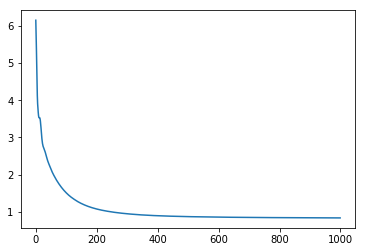

In [109]:
plt.figure()
plt.plot(-1 * np.asnumpy(hist[hist != -1]))

## Now for the actual training

In [128]:
weight_optimizer = MomentumSGD(0.001,0.9)
bias_optimizer = MomentumSGD(0.001,0.9)
nn = FCNN([784,100,100,10],kaiming_uniform,kaiming_uniform,relu,crossentropy_with_logits,weight_optimizer,bias_optimizer)

In [129]:
indices = np.arange(len(mnist_label),dtype=np.int32)
np.random.shuffle(indices)

#### Data is p big lets save 10% for test (around 420 for each classes)

In [130]:
cutoff = int(len(indices) * 0.9)

In [131]:
indices_train = indices[:cutoff]
indices_test = indices[cutoff:]

In [132]:
train_pix, train_lab = mnist_pixels[indices_train], mnist_label[indices_train].astype(np.int32)
test_pix, test_lab = mnist_pixels[indices_test], mnist_label[indices_test].astype(np.int32)

In [133]:
fit_history = nn.fit(train_pix,train_lab,32,30)

Epoch 0 done. Loss : -2.4434407015403283
Epoch 1 done. Loss : -1.8918493607282805
Epoch 2 done. Loss : -1.786249723965854
Epoch 3 done. Loss : -1.7362623263567718
Epoch 4 done. Loss : -1.473684150119267
Epoch 5 done. Loss : -1.3613021797628535
Epoch 6 done. Loss : -1.1905503184162374
Epoch 7 done. Loss : -0.9751635978831469
Epoch 8 done. Loss : -0.9409462389425086
Epoch 9 done. Loss : -0.9186944744064667
Epoch 10 done. Loss : -0.9000113158842595
Epoch 11 done. Loss : -0.8824212386964987
Epoch 12 done. Loss : -0.8684067006994711
Epoch 13 done. Loss : -0.8558958785152863
Epoch 14 done. Loss : -0.8451983664009108
Epoch 15 done. Loss : -0.8344435987438921
Epoch 16 done. Loss : -0.825193829165995
Epoch 17 done. Loss : -0.8176260243207029
Epoch 18 done. Loss : -0.8097760853762821
Epoch 19 done. Loss : -0.8016564636856647
Epoch 20 done. Loss : -0.7954060340688875
Epoch 21 done. Loss : -0.7887451078576948
Epoch 22 done. Loss : -0.7830223583956986
Epoch 23 done. Loss : -0.7779976055419237
Epoch

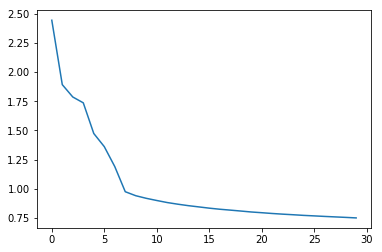

In [134]:
plt.figure()
plt.plot(np.asnumpy(fit_history[fit_history != -1]) * -1)

## Performance of FCNN trained with normal backpropagation

In [135]:
print(f"Performance on training data : {nn.score(train_pix,train_lab)} %")

Performance on training data : 88.22486772486772 %


In [136]:
print(f"Performance on test data : {nn.score(test_pix,test_lab)} %")

Performance on test data : 86.90476190476191 %


**Not good, but eh, not our main goal.**

# Score-trained NN

Just remember to make it extra wide.

In [39]:
class ScoreFCNN(object):
    
    def __init__(self, layers_size,topKPercentage,initializer_weight,initializer_score,activation,loss_function,optimizer):
#         assert len(layers_size) == (len(topKPercentage)+1)
        self.layers_size = layers_size
        self.weights = [initializer_weight((k,j)) for j,k in zip(layers_size[:-1],layers_size[1:])]
        self.scores = [initializer_score(w.shape) for w in self.weights]
        self.topK = [int(j*k*topKPercentage) for j,k in zip(layers_size[:-1],layers_size[1:])]
        assert len(self.weights) == len(self.scores)
        self.activation = activation
        self.loss_function = loss_function
        self.optimizer = optimizer
    
    def feedforward(self,X):
        a = X
        zs = []
        acs = [a]
        for w,s,k in zip(self.weights,self.scores,self.topK):
            ss = s.copy()
            ww = w.copy()
#             assert not np.shares_memory(ss,s)
#             assert not np.shares_memory(ww,w)
#             ss = np.abs(ss)
            ss_flat = ss.ravel()
            sort_idx = ss_flat.argsort()
            ss_flat[sort_idx[-k:]] = 1
            ss_flat[sort_idx[:-k]] = 0
            assert ss.shape == w.shape
            ww = ww * ss
#             print(ww)
#             print(ww.shape)
            a = np.dot(ww,a)
            zs.append(a)
            a = self.activation(a)
            acs.append(a)
        return a, zs, acs
    
    def feedforward_softmax(self,X):
        final_a, _, _ = self.feedforward(X)
        final_a = np.exp(final_a)
        final_a = final_a / np.sum(final_a,axis=0)
        return final_a
    
    def backpropagation(self,X,y):
        input_dim, batch_size = X.shape
        final_activation, zs, acs = self.feedforward(X)
        delta_s = [np.zeros(s.shape) for s in self.scores]
        error = self.loss_function(final_activation,y,prime=True) * self.activation(zs[-1],True)
        delta_s[-1] += np.einsum('ik,jk->ijk',error,acs[-2]).mean(axis=2)
        for i in range(2,len(self.layers_size)):
            error = np.einsum('ik,ij->jk',error,self.weights[-i+1]) * self.activation(zs[-i],prime=True)
            delta_s[-i] += np.einsum('ik,jk->ijk',error,acs[-i-1]).mean(axis=2) * self.weights[-i]
        return delta_s
    
    def fit(self,X,y,batch_size,epochs):
        # expecting X and y to be already numpy array with the num_samples as 
        # 1st dim
        history = np.zeros(epochs)
        history -= 1
        index = 0
        for epoch in range(epochs):
            indices = np.arange(X.shape[0],dtype=np.int32)
            np.random.shuffle(indices)
            X = X.copy()[indices,:]
            y = y.copy()[indices]
            i = 0
            batches_X = [X[k:k+batch_size] for k in range(0,X.shape[0],batch_size)]
            batches_y = [y[k:k+batch_size] for k in range(0,y.shape[0],batch_size)]
            losses = 0
            for Xb, yb in zip(batches_X,batches_y):
                delta_s = self.backpropagation(Xb.T, yb.T)
#                 print(delta_w)
                self.scores = self.optimizer(delta_s,self.scores)
                logits,_,_ = self.feedforward(Xb.T)
                losses += self.loss_function(logits,yb.T) / (Xb.shape[0] * len(batches_X))
#                 print((Xb.shape[0] * len(batches_X)))
            history[index] = losses
            index += 1
            print(f"Epoch {epoch} done. Loss : {losses}")
        return history
    
    def predict(self,X):
        softmaxed = self.feedforward_softmax(X.T)
        preds = np.argmax(softmaxed,axis=0)
        return preds
    
    def score(self, X, y):
        preds = self.predict(X)
        assert preds.shape == y.shape
        return np.mean(preds == y) * 100

**First i overfit the model to make sure everything works**

In [40]:
optimizer = MomentumSGD(0.1,0.9)
scorenn = ScoreFCNN([784,200,200,10],0.5,kaiming_uniform,kaiming_uniform,relu,crossentropy_with_logits,optimizer)

In [41]:
hist = scorenn.fit(smol_batch_pixels,smol_batch_label,32,1000)

Epoch 0 done. Loss : -3.254286697408928
Epoch 1 done. Loss : -3.254420999055565
Epoch 2 done. Loss : -3.254345638803724
Epoch 3 done. Loss : -3.256071298072444
Epoch 4 done. Loss : -3.2544446640152427
Epoch 5 done. Loss : -3.2522423637977833
Epoch 6 done. Loss : -3.2450392907832435
Epoch 7 done. Loss : -3.2428270703453475
Epoch 8 done. Loss : -3.2329419304452927
Epoch 9 done. Loss : -3.228260604754415
Epoch 10 done. Loss : -3.2274933061356217
Epoch 11 done. Loss : -3.214015058711537
Epoch 12 done. Loss : -3.2087268111046656
Epoch 13 done. Loss : -3.202216239412928
Epoch 14 done. Loss : -3.199149583594897
Epoch 15 done. Loss : -3.1946125415995423
Epoch 16 done. Loss : -3.1881772960009083
Epoch 17 done. Loss : -3.170545669980716
Epoch 18 done. Loss : -3.1690056311651533
Epoch 19 done. Loss : -3.1601544924168348
Epoch 20 done. Loss : -3.158524924727108
Epoch 21 done. Loss : -3.1484206714297613
Epoch 22 done. Loss : -3.141720204548985
Epoch 23 done. Loss : -3.1360112889344096
Epoch 24 done

Epoch 206 done. Loss : -2.0979197704273638
Epoch 207 done. Loss : -2.105969444995205
Epoch 208 done. Loss : -2.097096501952854
Epoch 209 done. Loss : -2.0978541152320904
Epoch 210 done. Loss : -2.0903375508372757
Epoch 211 done. Loss : -2.098020551905582
Epoch 212 done. Loss : -2.0928926264154275
Epoch 213 done. Loss : -2.0921934245281575
Epoch 214 done. Loss : -2.1133597624745386
Epoch 215 done. Loss : -2.162434721027939
Epoch 216 done. Loss : -2.133442064286278
Epoch 217 done. Loss : -2.1052993048528306
Epoch 218 done. Loss : -2.081416880655172
Epoch 219 done. Loss : -2.108566563540893
Epoch 220 done. Loss : -2.094280543805209
Epoch 221 done. Loss : -2.0967709548548767
Epoch 222 done. Loss : -2.0689150052761196
Epoch 223 done. Loss : -2.075961388474723
Epoch 224 done. Loss : -2.075134970125879
Epoch 225 done. Loss : -2.0634225833885376
Epoch 226 done. Loss : -2.0565772858076365
Epoch 227 done. Loss : -2.0535643992179238
Epoch 228 done. Loss : -2.047338257241284
Epoch 229 done. Loss :

Epoch 408 done. Loss : -1.7025883477365578
Epoch 409 done. Loss : -1.6663158789420986
Epoch 410 done. Loss : -1.655739043317351
Epoch 411 done. Loss : -1.653407751406313
Epoch 412 done. Loss : -1.6524934309416803
Epoch 413 done. Loss : -1.6568516352129818
Epoch 414 done. Loss : -1.6545267413638354
Epoch 415 done. Loss : -1.6553205571069802
Epoch 416 done. Loss : -1.6565641855810014
Epoch 417 done. Loss : -1.6508646733428858
Epoch 418 done. Loss : -1.6484162843403738
Epoch 419 done. Loss : -1.6447398786521241
Epoch 420 done. Loss : -1.637912828182667
Epoch 421 done. Loss : -1.633286649370734
Epoch 422 done. Loss : -1.6253424919853112
Epoch 423 done. Loss : -1.6293904927651206
Epoch 424 done. Loss : -1.6295008609101083
Epoch 425 done. Loss : -1.6302265276582253
Epoch 426 done. Loss : -1.6375521333451677
Epoch 427 done. Loss : -1.632609626043803
Epoch 428 done. Loss : -1.6282055899288
Epoch 429 done. Loss : -1.6244446930314531
Epoch 430 done. Loss : -1.621092800481685
Epoch 431 done. Loss

Epoch 602 done. Loss : -1.5078618471783423
Epoch 603 done. Loss : -1.5220213718516495
Epoch 604 done. Loss : -1.5079744583464163
Epoch 605 done. Loss : -1.5053216181502054
Epoch 606 done. Loss : -1.5059189426620185
Epoch 607 done. Loss : -1.505704836702164
Epoch 608 done. Loss : -1.4998466035270608
Epoch 609 done. Loss : -1.5030036365164694
Epoch 610 done. Loss : -1.4855192082057451
Epoch 611 done. Loss : -1.4977057284018556
Epoch 612 done. Loss : -1.498346179973666
Epoch 613 done. Loss : -1.4858931238836657
Epoch 614 done. Loss : -1.4734011961850293
Epoch 615 done. Loss : -1.4751055287645396
Epoch 616 done. Loss : -1.4755140200334371
Epoch 617 done. Loss : -1.4769490386803499
Epoch 618 done. Loss : -1.4650841245608475
Epoch 619 done. Loss : -1.469117415787281
Epoch 620 done. Loss : -1.4692392179882305
Epoch 621 done. Loss : -1.4807682913101454
Epoch 622 done. Loss : -1.483922692226192
Epoch 623 done. Loss : -1.4823515155202807
Epoch 624 done. Loss : -1.4747461788809004
Epoch 625 done.

Epoch 797 done. Loss : -1.3607315436892482
Epoch 798 done. Loss : -1.3644461172129918
Epoch 799 done. Loss : -1.3579318009861576
Epoch 800 done. Loss : -1.3633159339132384
Epoch 801 done. Loss : -1.3598759462731107
Epoch 802 done. Loss : -1.3594582180028645
Epoch 803 done. Loss : -1.360185346578949
Epoch 804 done. Loss : -1.359970199911938
Epoch 805 done. Loss : -1.3533687450939216
Epoch 806 done. Loss : -1.3566014056044646
Epoch 807 done. Loss : -1.347454004995342
Epoch 808 done. Loss : -1.3591149374009523
Epoch 809 done. Loss : -1.3516362710408676
Epoch 810 done. Loss : -1.3523156897677706
Epoch 811 done. Loss : -1.3515688319201522
Epoch 812 done. Loss : -1.3544218633899325
Epoch 813 done. Loss : -1.350735107365076
Epoch 814 done. Loss : -1.3572720953138915
Epoch 815 done. Loss : -1.3568755490597109
Epoch 816 done. Loss : -1.3510879352044152
Epoch 817 done. Loss : -1.3444936262787155
Epoch 818 done. Loss : -1.3534972965697274
Epoch 819 done. Loss : -1.3849783401066031
Epoch 820 done.

Epoch 992 done. Loss : -1.2789897425857635
Epoch 993 done. Loss : -1.2684387912168864
Epoch 994 done. Loss : -1.2753409739997412
Epoch 995 done. Loss : -1.2803697521010635
Epoch 996 done. Loss : -1.2808212110673867
Epoch 997 done. Loss : -1.2770190506111607
Epoch 998 done. Loss : -1.275981793016634
Epoch 999 done. Loss : -1.279428813044226


#### Seems nice, not all the way to 0 but still

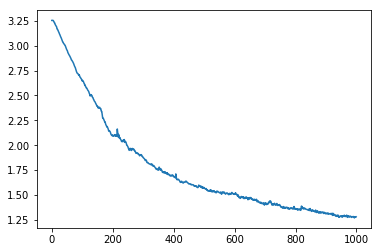

In [42]:
plt.figure()
plt.plot(np.asnumpy(hist) * -1)

#### Probs have something to do with the depth / width, at least we know it works

In [43]:
scorenn.score(smol_batch_pixels,smol_batch_label)

array(75.)

Testing on a deeper and wider model.

According to the paper, wider is better, even at constant parameter count.

For starters, lets keep the 3 layers model, and make the hidden layers 1.25 times larger

In [44]:
newoptimizer = MomentumSGD(0.1,0.9)
newscorenn = ScoreFCNN([784,250,250,10],0.5,kaiming_uniform,kaiming_uniform,relu,crossentropy_with_logits,newoptimizer)

In [45]:
history = newscorenn.fit(train_pix,train_lab,32,30)

Epoch 0 done. Loss : -1.366654148614845
Epoch 1 done. Loss : -0.7548565746333639
Epoch 2 done. Loss : -0.6647547590747273
Epoch 3 done. Loss : -0.6182624409086726
Epoch 4 done. Loss : -0.5890809499713148
Epoch 5 done. Loss : -0.5678289053198993
Epoch 6 done. Loss : -0.5537977337469943
Epoch 7 done. Loss : -0.5436931543693861
Epoch 8 done. Loss : -0.533298736969031
Epoch 9 done. Loss : -0.5255640931043379
Epoch 10 done. Loss : -0.5184975245171914
Epoch 11 done. Loss : -0.511306219331956
Epoch 12 done. Loss : -0.5065656876599476
Epoch 13 done. Loss : -0.5015888751143414
Epoch 14 done. Loss : -0.4974471026562326
Epoch 15 done. Loss : -0.4935790075501466
Epoch 16 done. Loss : -0.49239863568544867
Epoch 17 done. Loss : -0.48925819684856436
Epoch 18 done. Loss : -0.4860569523654004
Epoch 19 done. Loss : -0.483196614880527
Epoch 20 done. Loss : -0.4806344358986533
Epoch 21 done. Loss : -0.4795808011186713
Epoch 22 done. Loss : -0.4769004519982314
Epoch 23 done. Loss : -0.4757380251808122
Epoc

# Performance of Score NN

In [49]:
print(f"Performance on training data : {newscorenn.score(train_pix,train_lab)} %")

Performance on training data : 93.44973544973544 %


In [50]:
print(f"Performance on training data : {newscorenn.score(test_pix,test_lab) } %")

Performance on training data : 92.80952380952381 %
